In [189]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import random_split
%matplotlib inline

In [190]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))
print(words[:8])

32033
15
2
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [191]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")

ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(ctoi)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
27


In [192]:
train_wd, valid_wd, test_wd = random_split(words, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(420))

In [193]:
def pad(string, char, length):
    d = length - len(string)
    return string + char * d
    
pad("apple", ".", 10)

'apple.....'

In [194]:
[pad("."*3+w, ".", 15) for w in words][:10]

['...emma........',
 '...olivia......',
 '...ava.........',
 '...isabella....',
 '...sophia......',
 '...charlotte...',
 '...mia.........',
 '...amelia......',
 '...harper......',
 '...evelyn......']

Building dataset: 

Each example is padded with starting symbols (`.`). The number of pad equals to kernal size of conv layer. i.e. when context_size = 4
```
....emma
```

And each example is a 1D tensor of size `(seq_length)`, where each elements contains character index.

In [195]:
context_size = 4

def char_idx(word):
    return [ctoi[c] for c in word]

def build_dataset(words):
    X = []
    Y = []
    
    for w in words:
        x = "." * context_size + w
        y = w + "."
        X.append(torch.tensor(char_idx(x)))
        Y.append(torch.tensor(char_idx(y)))

    return X, Y

train_x, train_y = build_dataset(train_wd)
valid_x, valid_y = build_dataset(valid_wd)

In [196]:
print(train_wd[0])
print(train_x[0])

jaysen
tensor([ 0,  0,  0,  0, 10,  1, 25, 19,  5, 14])


In [197]:
class Transpose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.T
    
    def string(self):
        return "Transpose"

In [198]:
class Permute(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.permute(self.dim)
    
    def string(self):
        return "Permute"

In [199]:
class Inspect(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.x = x
        return x

In [200]:
@torch.no_grad()
def eval_split():
    lossi = []
    for x, y in zip(valid_x, valid_y):
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        lossi.append(loss.item())
        
    return torch.tensor(lossi).mean()

The input size is: `word_length + 3`

- After 1st conv: `word_length + 2`
- After 2nd conv: `word_length + 1`
- After 2nd conv: `word_length`


In [202]:
embed_size = 24
hidden_size = 256

# input (seq)
model = nn.Sequential(
    nn.Embedding(vocab_size, embed_size), # (seq, embed)
    Transpose(), # (embed, seq)

    # num of conv layer = context_size - 1
    nn.Conv1d(in_channels=embed_size, out_channels=256, kernel_size=2), # (hidden, seq)
    nn.Tanh(),

    nn.Conv1d(in_channels=256, out_channels=128, kernel_size=2), # (hidden, seq)
    nn.Tanh(),

    nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2), # (hidden, seq)
    nn.Tanh(),

    Transpose(), # (seq, hidden)
    
    nn.Linear(64, vocab_size),
)

for p in model.parameters():
    p.requires_grad = True
    
print(sum((p.nelement() for p in model.parameters())))

97059


In [ ]:
import random

optimizer = torch.optim.Adam(model.parameters())
lossi = []

for _ in range(20):
    ds = list(zip(train_x, train_y))
    random.shuffle(ds)
    
    for x, y in ds:
        optimizer.zero_grad()
        
        logits = model(x)    
        loss = F.cross_entropy(logits, y)
        loss.backward()

        optimizer.step()
        lossi.append(loss.item())

        if len(lossi) % 10000 == 1:
            avg = torch.tensor(lossi[-10000:]).mean()
            print(f"{avg:.4f}")

3.4028
2.3480
2.2626
2.2460
2.2394
2.2301
2.2225
2.2138
2.2177
2.2106
2.2102
2.2121
2.1982
2.1997
2.2033
2.1979
2.1926
2.1950
2.2047
2.1938
2.1969
2.1962
2.1873
2.1899
2.1862
2.1955
2.1903
2.1802
2.1906
2.1883
2.1891
2.1780
2.1847
2.1801
2.1814
2.1853
2.1824
2.1811
2.1821
2.1794
2.1799
2.1823
2.1798
2.1815
2.1820
2.1849
2.1764


In [ ]:
valid_loss = eval_split()
print(f"train: {torch.tensor(lossi[-10000:]).mean():.4f}")
print(f"valid: {valid_loss:.4f}")
print(f"baseline (random):: { -torch.tensor(1/26).log() }")

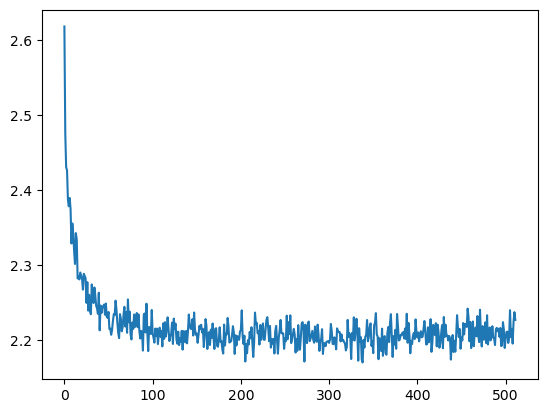

In [183]:
bucket = 1000
clip = len(lossi) - (len(lossi) % bucket)

l = torch.tensor(lossi[0:clip])
l = l.view(-1, bucket).mean(1)
plt.plot(l)

#### Log

Single example stocastic gradient
- train: 2.2232
- valid: 2.2155
  
Mini-batch gradient descent (embed_size: 16, hidden_size: 64)
- train: 2.0666
- valid: 2.1058

3 layer casual conv (kernel = 4, 3 conv layer, embed_size = 10, hidden_size = 128)
- train: 2.1893
- valid: 2.1989

In [188]:
for _ in range(10):
    sample = [0] * context_size

    while(True):
        ctx = sample[-context_size:] 
        ctx = torch.tensor(ctx)
        logits = model(ctx) # (1, 27)
        prob = F.softmax(logits, 1).view(-1)
        idx = torch.multinomial(prob, 1).item()
        sample.append(idx)

        if idx == 0 or len(sample) > 50:
            break

    word = "".join([itoc[idx] for idx in sample[context_size:-1]])
    print(word)

keega
jazayushus
jaiox
nohley
leitemisa
pamonna
asenter
xiana
naisa
hhanis
